In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
import torch
from torch import nn
from torchvision.transforms import v2

In [40]:
from project.data.cvc_clinic import ClinicDB

transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])

target_transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])

transform

Compose(
      PILToTensor()
      ToDtype(scale=True)
)

In [41]:
dataset_root = "../data/"

dataset = ClinicDB(dataset_root, split="train", transform=transform, target_transform=target_transform)
dataset.data.shape

(428, 288, 384, 3)

In [49]:
train_loader = dataset.get_loader(batch_size=5, shuffle=True)
train_loader

In [50]:
for i, (data, target) in enumerate(train_loader):
    print(data.shape, target.shape)
    print(type(data), type(target))
    print(data.dtype, target.dtype)
    print(data[:, :, 50:80, 50:80])  # The image has some black padding, so we peek into the center
    break

torch.Size([5, 3, 288, 384]) torch.Size([5, 1, 288, 384])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.float32 torch.float32
tensor([[[[0.0824, 0.0824, 0.0824,  ..., 0.4118, 0.4157, 0.4196],
          [0.0824, 0.0824, 0.0824,  ..., 0.4157, 0.4235, 0.4275],
          [0.0824, 0.0824, 0.0824,  ..., 0.4157, 0.4235, 0.4275],
          ...,
          [0.4000, 0.3961, 0.4039,  ..., 0.4902, 0.4902, 0.4902],
          [0.4078, 0.4039, 0.4039,  ..., 0.4941, 0.4941, 0.4941],
          [0.4118, 0.4039, 0.4039,  ..., 0.5020, 0.5020, 0.5020]],

         [[0.0824, 0.0824, 0.0824,  ..., 0.2549, 0.2588, 0.2667],
          [0.0824, 0.0824, 0.0824,  ..., 0.2588, 0.2667, 0.2706],
          [0.0824, 0.0824, 0.0824,  ..., 0.2627, 0.2706, 0.2745],
          ...,
          [0.2196, 0.2157, 0.2235,  ..., 0.3176, 0.3176, 0.3176],
          [0.2275, 0.2235, 0.2235,  ..., 0.3216, 0.3216, 0.3216],
          [0.2314, 0.2235, 0.2235,  ..., 0.3294, 0.3294, 0.3294]],

         [[0.0824, 0.0824, 0.0824,  ..., 0

In [55]:
# Intersection over Union (IoU) loss
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets):
        # Sigmoid activation
        inputs = torch.sigmoid(inputs)
        
        # Flattening
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Intersection
        intersection = (inputs * targets).sum()
        
        # Union
        total = (inputs + targets).sum()
        
        # IoU
        IoU = (intersection + 1e-8) / (total - intersection + 1e-8)
        
        return (1 - IoU) * 100  # Scale to 0-100 to make it more interpretable

In [ ]:
from project.unet import UNet

model = UNet(n_channels=3, n_classes=1).to("cuda")
criterion = IoULoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(100):
    model.train()
    for i, (data, target) in enumerate(train_loader):
        data, target = data.to("cuda"), target.to("cuda")
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if i % 20 == 0:
            print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item()}")

Epoch 0, Batch 0, Loss: 89.75267791748047
Epoch 0, Batch 20, Loss: 84.24561309814453
Epoch 0, Batch 40, Loss: 86.90901184082031
Epoch 0, Batch 60, Loss: 73.2244873046875
Epoch 0, Batch 80, Loss: 84.82010650634766
Epoch 1, Batch 0, Loss: 78.21470642089844
Epoch 1, Batch 20, Loss: 67.93572998046875
Epoch 1, Batch 40, Loss: 79.71308135986328
Epoch 1, Batch 60, Loss: 80.30152130126953
Epoch 1, Batch 80, Loss: 70.32141876220703
Epoch 2, Batch 0, Loss: 55.14162826538086
Epoch 2, Batch 20, Loss: 88.08977508544922
Epoch 2, Batch 40, Loss: 92.36589050292969
Epoch 2, Batch 60, Loss: 86.03604888916016
Epoch 2, Batch 80, Loss: 63.761932373046875
Epoch 3, Batch 0, Loss: 75.44837951660156
Epoch 3, Batch 20, Loss: 67.01940155029297
Epoch 3, Batch 40, Loss: 87.61238098144531
Epoch 3, Batch 60, Loss: 49.20565414428711
Epoch 3, Batch 80, Loss: 60.1547966003418
Epoch 4, Batch 0, Loss: 58.31893539428711
Epoch 4, Batch 20, Loss: 66.40970611572266
Epoch 4, Batch 40, Loss: 46.909217834472656
Epoch 4, Batch 6

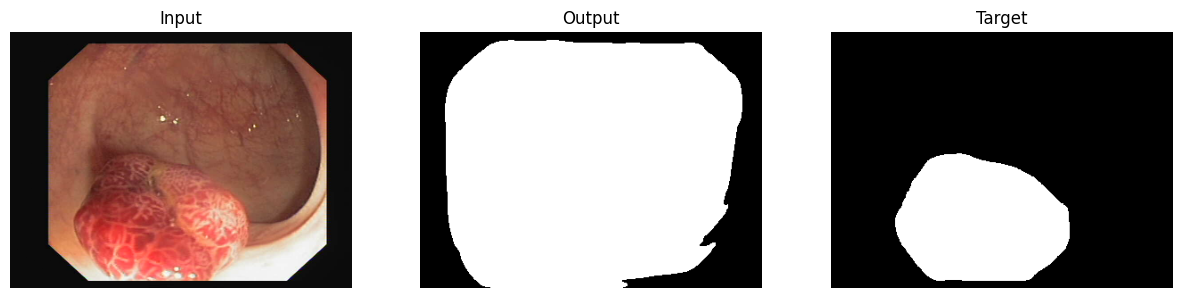

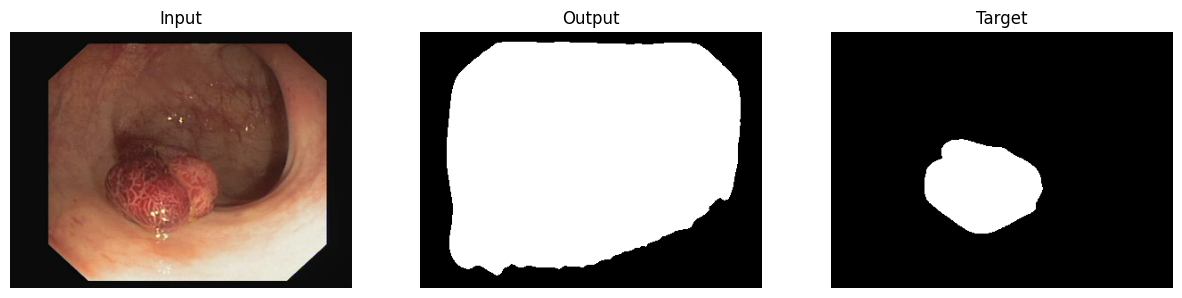

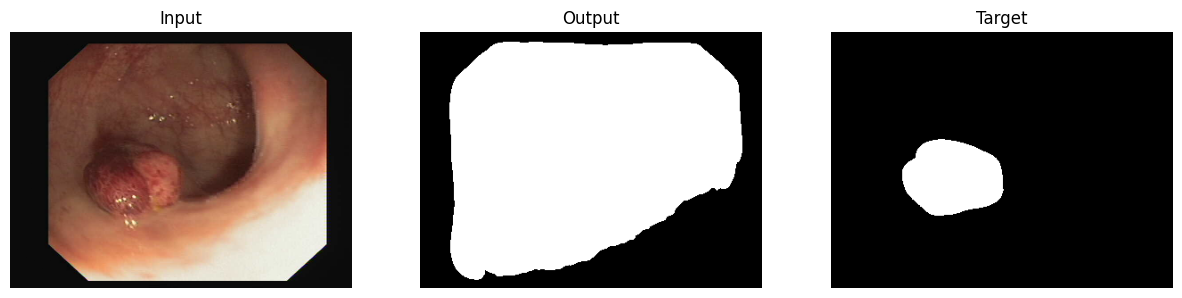

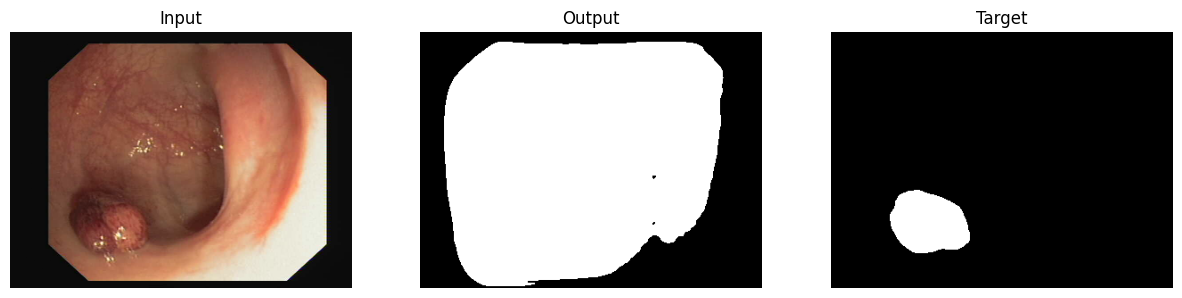

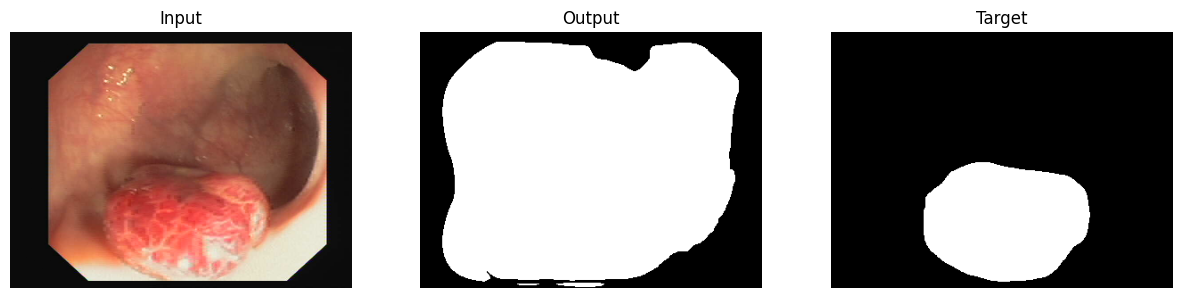

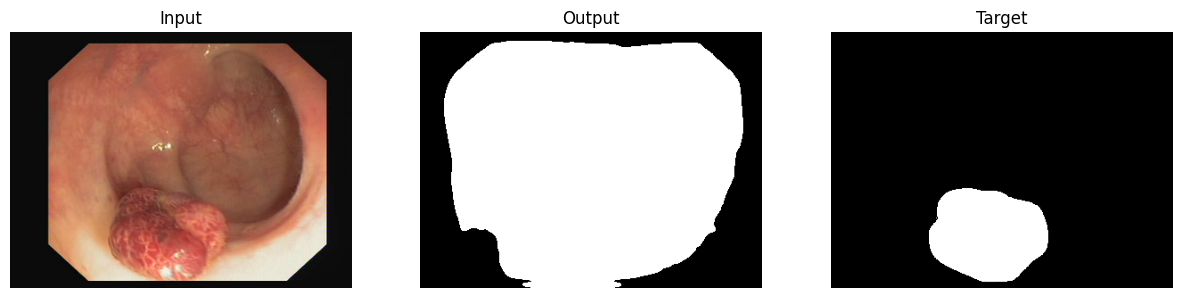

In [54]:
model.eval()
test_set = ClinicDB(dataset_root, split="test", transform=transform, target_transform=target_transform)
test_loader = test_set.get_loader(batch_size=1, shuffle=False)

for i, (data, target) in enumerate(test_loader):
    data, target = data.to("cuda"), target.to("cuda")
    output = model(data)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(data[0].cpu().numpy().transpose(1, 2, 0))
    plt.title("Input")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    
    # Sigmoid activation
    output = torch.sigmoid(output)
    output = (output > 0.5).float()
    
    plt.imshow(output[0].cpu().numpy().transpose(1, 2, 0).squeeze(), cmap="gray")
    plt.title("Output")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(target[0].cpu().numpy().transpose(1, 2, 0).squeeze(), cmap="gray")
    plt.title("Target")
    plt.axis("off")
    
    plt.show()
    
    if i == 5:
        break
    